## Classifying From Tabular Data

In [46]:
# To classify tabular data we use fastai.tabular
from fastai.tabular.all import * 
import matplotlib.pyplot as plt
import numpy
import random
from torch.utils.tensorboard import SummaryWriter

## Reading Data

In [2]:
# Path to data set
# Test data get partitioned into a separate file already now
from pathlib import Path
data_path = Path('./data/mecs/MECS_2-Phase-Steels.csv')

In [3]:
# Reading CSV file containing training and validation data
import pandas as pd
dataframe = pd.read_csv(data_path, sep=';')

# Looking at the first data
dataframe.head()

,class,equiv. diameter,major axis length,minor axis length,perimeter,equiv. radius,max feret diameter,min feret diameter,mean feret diameter,convex perimeter,...,std. relativ area,std. convex area/filled area,std. axial ratio,std. aspect ratio,std. roundness,std. circularity,std. sphericity,std. convex per./filled per.,std. form factor,std. convexity
0,category_3,15.225748,11.478270,6.516211,101.586092,7.612874,28.476331,14.601479,21.538905,69.846721,...,0.002630,0.360265,0.247471,0.172865,0.167522,0.150141,0.991127,0.257917,0.254766,0.725854
1,category_3,1.151113,0.974243,0.385487,5.609659,0.575557,2.580962,0.888856,1.734909,5.555157,...,0.193671,0.345320,0.108488,0.097143,0.104520,0.107560,0.357665,0.126119,0.195196,0.270121
2,category_3,1.450391,1.068283,0.524281,5.629028,0.725196,2.312959,1.144310,1.728635,5.545392,...,0.102618,0.441363,0.205836,0.167468,0.075052,0.079354,0.199565,0.134383,0.116518,0.255049
3,category_3,3.561641,2.350421,1.400185,13.099335,1.780821,5.162738,3.039382,4.101060,12.632860,...,0.040841,0.347140,0.234101,0.159523,0.160860,0.144939,1.299666,0.328635,0.253970,1.025188
4,category_3,6.676158,5.226249,2.784733,35.279133,3.338079,12.536480,6.907373,9.721926,30.297397,...,0.009716,0.257991,0.253047,0.162753,0.156650,0.134192,1.073103,0.273935,0.238783,0.793738


## Data Loading and Encoding 

In [4]:
m = np.arange(6).reshape(3,2).mean(axis=0)
s = np.arange(6).reshape(3,2).std(axis=0)

In [5]:
batch_size = 4
n_features = len(dataframe.columns)-1

def extract_numpy_from_df( dataframe: pd.DataFrame, y_column: int ):
    y_column_name = dataframe.columns[y_column]
    X = dataframe.drop(y_column_name, axis=1).to_numpy(dtype=np.float32)
    Y = dataframe[y_column_name].to_numpy()
    return X,Y

def clean_data( X ):
    X = X[~np.isnan(X).any(axis=1)]
    return X
    
def get_validation_and_training_indices( dataset_length ):
    indices = np.random.permutation(dataset_length)
    t = int(dataset_length * 0.8)

    return indices[:t], indices[t:]

def normalize( X ):
    m = X.mean(axis=0)
    s = X.std(axis=0)
    
    return (X - m) / s 

def hot_1_encode( Y, codes ):
    Y_encoded = np.zeros((Y.shape[0], len(codes)))
    for i, elem in enumerate(Y):
        Y_encoded[i, codes.get(elem)] = 1
    
    return Y_encoded

def create_batch( permutation, batch_no, batch_size, X ):
    indices = permutation[batch_no * batch_size: batch_no * batch_size + batch_size]
    x_batch = torch.zeros( [ len(indices), X.shape[1] ], dtype=torch.float32 )
    
    for i in range(len(indices)):
        x_batch[i] = torch.from_numpy(X[indices[i]])
    return x_batch

codes = { 'category_1' : 0, 'category_2' : 1, 'category_3' : 2 }

X,Y = extract_numpy_from_df( dataframe, 0 )
X   = clean_data( X )
indices_train,indices_validation = get_validation_and_training_indices( X.shape[0] )

X   = normalize( X )
Y   = hot_1_encode( Y, codes )

## Creating a Network Architecture

In [38]:
def create_model( n_in, n_hidden, n_out ):
    layer = []
    if n_hidden:
        layer.append(nn.Linear(n_in, n_hidden[0]))
        layer.append(nn.ReLU())
        for i in range(len(n_hidden) - 1):
            layer.append(nn.Linear(n_hidden[i], n_hidden[i + 1]))
            layer.append(nn.ReLU())
        layer.append(nn.Linear(n_hidden[-1], n_out))
    else:
        layer.append(nn.Linear(n_in, n_out))

    model = nn.Sequential( *layer )
    return model

## Training Loop

In [57]:
def accuracy_metric( y, y_hat ):
    y     = torch.argmax(y, dim=1).to(torch.float32)
    y_hat = torch.argmax(y_hat, dim=1).to(torch.float32)
    difference = y_hat-y
    return 1.0 - torch.mean( torch.abs( difference ) ).item() 

def train_one_epoch( epoch_index, indices_train, X, Y, optimizer, loss_fn, batch_size ):
    no_train_batches = int(len(indices_train) / batch_size)
    losses           = []
    accuracies       = []

    for batch_no in range(no_train_batches):
        x = create_batch(indices_train, batch_no, batch_size, X)
        y = create_batch(indices_train, batch_no, batch_size, Y)

        optimizer.zero_grad()
        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append(accuracy_metric(y, y_pred))
    writer.add_scalar("Loss/train", np.mean(losses), epoch_index)
    writer.add_scalar("Accuracy/train", np.mean(accuracies), epoch_index)
    return np.mean(losses), np.mean(accuracies)


def validate(epoch_index, indices_val, X, Y, loss_fn, batch_size):
    no_val_batches = int(len(indices_val) / batch_size)
    losses = []
    accuracies = []

    for batch_no in range(no_val_batches):
        x = create_batch(indices_val, batch_no, batch_size, X)
        y = create_batch(indices_val, batch_no, batch_size, Y)

        with torch.no_grad():
            y_pred = model(x)

            loss = loss_fn(y_pred, y)
            losses.append(loss.item())
            accuracies.append(accuracy_metric(y, y_pred))

    writer.add_scalar("Loss/val", np.mean(losses), epoch_index)
    writer.add_scalar("Accuracy/val", np.mean(accuracies), epoch_index)
    return np.mean(losses), np.mean(accuracies)


# for lr in [0.005, 0.001, 0.0005, 0.0001]:
for lr in [0.001]:
    # for batch_size in [32, 64, 128, 256]:
    for batch_size in [256]:
        model = create_model(X.shape[1], [50, 25], Y.shape[1])
        optimizer = torch.optim.Adam( params = model.parameters(), lr=lr )
        loss_fn   = torch.nn.CrossEntropyLoss()
        writer = SummaryWriter(comment=f"lr_{lr}_batchsize_{batch_size}_wide")

        losses_train           = []
        accuracies_train       = []
        losses_val           = []
        accuracies_val       = []
        n_epochs = 50
        for i in range (n_epochs):
            loss_train, acc_train = train_one_epoch( i, indices_train, X, Y, optimizer, loss_fn, batch_size )
            loss_val, acc_val = validate(i, indices_validation, X, Y, loss_fn, batch_size)
            losses_train.append(loss_train)
            accuracies_train.append(acc_train)
            losses_val.append(loss_val)
            accuracies_val.append(acc_val)
            print(f"Epoch {i} / {n_epochs}; acc_train: {accuracies_train[-1]:.4f}; acc_val: {accuracies_val[-1]:.4f}")

Epoch 0 / 50; acc_train: 0.5337; acc_val: 0.5801
Epoch 1 / 50; acc_train: 0.7294; acc_val: 0.8130
Epoch 2 / 50; acc_train: 0.8500; acc_val: 0.8765
Epoch 3 / 50; acc_train: 0.8854; acc_val: 0.8965
Epoch 4 / 50; acc_train: 0.9027; acc_val: 0.9062
Epoch 5 / 50; acc_train: 0.9117; acc_val: 0.9150
Epoch 6 / 50; acc_train: 0.9194; acc_val: 0.9214
Epoch 7 / 50; acc_train: 0.9267; acc_val: 0.9268
Epoch 8 / 50; acc_train: 0.9334; acc_val: 0.9297
Epoch 9 / 50; acc_train: 0.9392; acc_val: 0.9351
Epoch 10 / 50; acc_train: 0.9427; acc_val: 0.9385
Epoch 11 / 50; acc_train: 0.9453; acc_val: 0.9414
Epoch 12 / 50; acc_train: 0.9474; acc_val: 0.9453
Epoch 13 / 50; acc_train: 0.9493; acc_val: 0.9453
Epoch 14 / 50; acc_train: 0.9506; acc_val: 0.9463
Epoch 15 / 50; acc_train: 0.9521; acc_val: 0.9473
Epoch 16 / 50; acc_train: 0.9548; acc_val: 0.9468
Epoch 17 / 50; acc_train: 0.9569; acc_val: 0.9473
Epoch 18 / 50; acc_train: 0.9589; acc_val: 0.9478
Epoch 19 / 50; acc_train: 0.9605; acc_val: 0.9478
Epoch 20 /

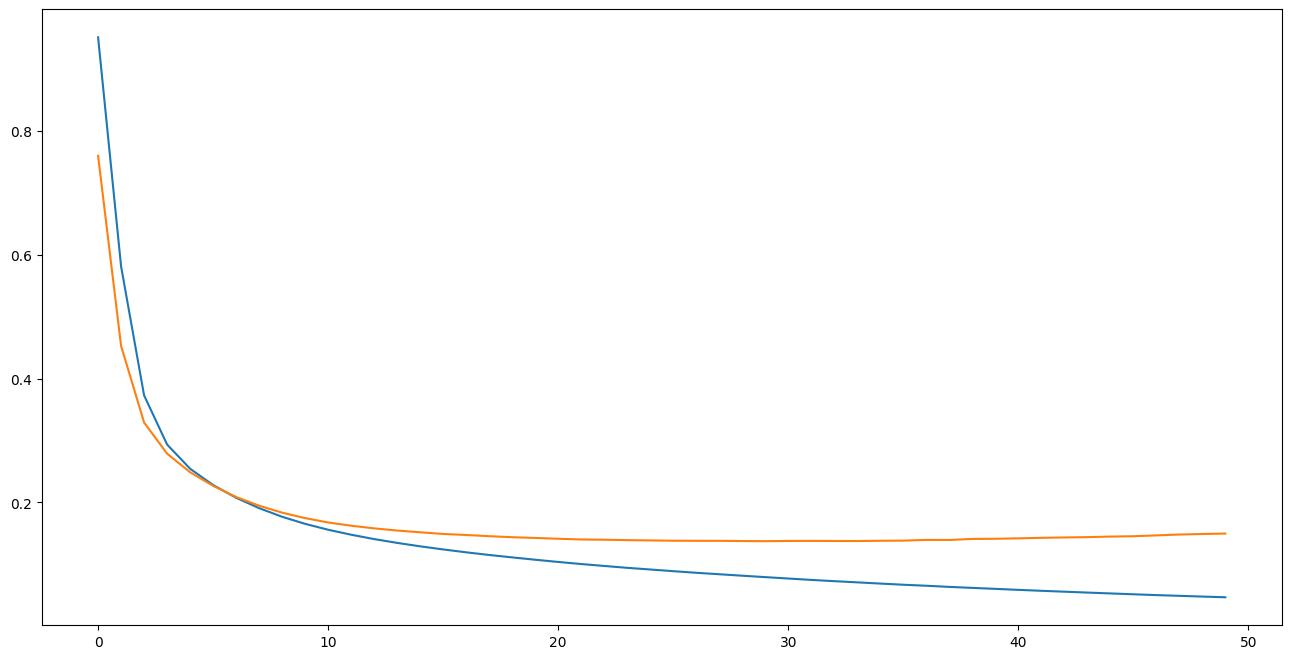

In [44]:
fig,axis = plt.subplots( 1,1, figsize=(16,8) )
axis.plot( losses_train )
axis.plot( losses_val )
plt.show()

## Hyper Parameter Tuning